<a href="https://colab.research.google.com/github/sirius59/ART_AI/blob/sirius59-patch/ART_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Binôme T: De Carvalho Mickael et Laisney Clément

algorithme qui prédit le style de l'oeuvre d'art (impressionnisme, pop art, cubisme etc...) et peut être je dit bien PEUT ETRE 
arriver à un algorithme qui créer une oeuvre en fonction du style demandé.

jeu de données:
https://www.kaggle.com/ikarus777/best-artworks-of-all-time

points de départ: 

- réseau de convolution
- réduction de dimension pour classer 

retrouvez notre travail sur https://github.com/sirius59/ART_AI

### Import libraries

In [68]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical

### Download the dataset from internet and extract it on the system

**We resized all images to 562x562 with a preview script available in the github page:** https://github.com/sirius59/ART_AI/blob/main/traitement%20des%20images.py

NB: replace the link by a new one using this URL in case of an issue like "file is not a zipfile" https://www.mediafire.com/file/v5jpwfjeldhmc8z/dataset_resized.zip/file

In [12]:
zipurl = 'https://download1638.mediafire.com/wsmlu2m3890g/v5jpwfjeldhmc8z/dataset_resized.zip'
with urlopen(zipurl) as zipresp:
  with ZipFile(BytesIO(zipresp.read())) as zfile:
    zfile.extractall()

# Core of the script

## Extracting metadata from artist.csv and labelize genres

In [69]:
artists=pd.read_csv('/content/dataset_resized/artists.csv')

##name of artists
artists['name'][19]='Albrecht_Durer' #fix ASCII problems
tmp=artists['name']
name=[tmp[i].replace(' ','_') for i in range(len(tmp))]#replace space by underscore, more convinent to import images

##genre of artists
tmp=artists['genre']
genre=[tmp[i].replace(',','/') for i in range(len(tmp))]#replace coma by slash, avoid mistakes in list

##number of paintings by artists
nb_paints=artists['paintings']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Labelize a genre with a number

In [70]:
#genre_label={'Expressionism':1,'Abstractionism':2,'Social Realism':3,'Muralism':4,'Impressionism':5,'Surrealism':6,'Byzantine Art':7,'Post-Impressionism':8,'Symbolism':9,'Art Nouveau':10,'Northern Renaissance':11,'Suprematism':12,'Cubism':13,'Baroque':14,'Romanticism':15,'Primitivism':16,'Mannerism':17,'Proto Renaissance':18,'Early Renaissance':19,'High Renaissance':20,'Neoplasticism':21,'Pop Art':22,'Abstract Expressionism':23}
#labelize a genre by a number

In [71]:
genre_label={'Impressionism':0,'Baroque':1}

In [72]:
nb_classes=len(genre_label)

Function to find the key associated with the label

In [73]:
def find_key(v): 
    for k, val in genre_label.items(): 
        if v == val: 
            return k 
    return "Key does not exist"

## Append all artworks in a list (for later)

In [74]:
#artworks=[]#list of [img,artist,genre]
#for i in range(len(name)):
#  for j in range(nb_paints[i]):
#    data=[plt.imread(f'/content/dataset_resized/resized/{name[i]}_{j+1}.jpg'),name[i],genre[i]] #[img,artist,genre]
#    artworks.append(data)

## Append artworks of 2 differents styles in a list
We choose 2 differents styles well represented in the dataset en choose 4 artists of each genre in order to have about 50/50 in term of artworks

In [75]:
input_shape=plt.imread(f'/content/dataset_resized/resized/{name[0]}_{1}.jpg').shape
artworks=[]
artworks_genre=[]
genre1=(3,14,15,20,25,27,31) #~50/50 impressionism/Baroque (maybe include less images to save RAM)
for i in genre1:
  for j in range(nb_paints[i]):
    artworks.append(plt.imread(f'/content/dataset_resized/resized/{name[i]}_{j+1}.jpg'))
    artworks_genre.append(genre[i])
artworks=np.array(artworks) #images
artworks_genre=np.array(artworks_genre) #string of the genre
artworks_label=np.array([genre_label[artworks_genre[i]] for i in range(len(artworks_genre))]) #integer corresponding to the genre

We choose to represent 2 differents artworks of each genre in order to visualize datas

Text(0.5, 1.0, 'Baroque')

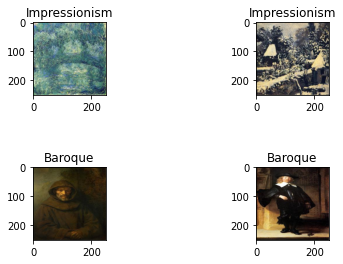

In [76]:
plt.figure()
plt.subplots_adjust(wspace=1, hspace=1)
plt.subplot(221)
plt.imshow(artworks[0])
plt.title(f'{artworks_genre[0]}')
plt.subplot(222)
plt.imshow(artworks[300])
plt.title(f'{artworks_genre[300]}')
plt.subplot(223)
plt.imshow(artworks[-1])
plt.title(f'{artworks_genre[-1]}')
plt.subplot(224)
plt.imshow(artworks[-200])
plt.title(f'{artworks_genre[-200]}')

## Shuffle and split of the dataset

In [77]:
prepared_label=to_categorical(artworks_label,num_classes=nb_classes)

In [78]:
x_train,x_test,y_train,y_test=train_test_split(artworks,prepared_label, test_size=0.33, random_state=42, shuffle=True)

## CNN

In [79]:
model=Sequential()

model.add(Conv2D(64, kernel_size=5, activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(128, kernel_size=4, activation='relu'))
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Dense(100, activation='relu'))

model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(nb_classes, activation='softmax'))

In [80]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [81]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 246, 246, 64)      4864      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 123, 123, 64)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 120, 120, 128)     131200    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 118, 118, 128)     147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 59, 59, 128)       0         
_________________________________________________________________
dense_4 (Dense)              (None, 59, 59, 100)       12900     
_________________________________________________________________
dropout_2 (Dropout)          (None, 59, 59, 100)      

In [82]:
model.fit(x_train,y_train, batch_size=64, epochs=10, validation_split=0.33)

Epoch 1/10
9/9 [==============================] - 4s 422ms/step - loss: 334.2778 - accuracy: 0.4928 - val_loss: 59.8437 - val_accuracy: 0.5108
Epoch 2/10
9/9 [==============================] - 4s 398ms/step - loss: 31.9916 - accuracy: 0.5562 - val_loss: 5.8085 - val_accuracy: 0.6295
Epoch 3/10
9/9 [==============================] - 4s 399ms/step - loss: 8.3867 - accuracy: 0.6572 - val_loss: 3.8783 - val_accuracy: 0.6655
Epoch 4/10
9/9 [==============================] - 4s 401ms/step - loss: 2.0280 - accuracy: 0.7683 - val_loss: 1.1311 - val_accuracy: 0.8165
Epoch 5/10
9/9 [==============================] - 4s 401ms/step - loss: 0.7249 - accuracy: 0.8280 - val_loss: 0.4896 - val_accuracy: 0.8885
Epoch 6/10
9/9 [==============================] - 4s 401ms/step - loss: 0.3731 - accuracy: 0.8639 - val_loss: 0.4044 - val_accuracy: 0.8705
Epoch 7/10
9/9 [==============================] - 4s 404ms/step - loss: 0.2629 - accuracy: 0.9066 - val_loss: 0.4166 - val_accuracy: 0.8561
Epoch 8/10
9/9 [

In [84]:
predict=model.predict(x_test)

In [85]:
label_prediction=np.argmax(predict, axis=1)
label_solution=np.argmax(y_test, axis=1)

Text(0.5, 1.0, 'prediction:Baroque\n solution:Baroque')

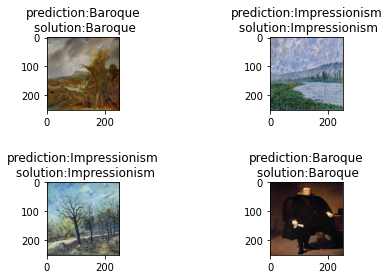

In [86]:
r1,r2,r3,r4=np.random.randint(len(y_test),size=4)
plt.figure()
plt.subplots_adjust(wspace=1, hspace=1)
plt.subplot(221)
plt.imshow(x_test[r1])
plt.title(f'prediction:{find_key(label_prediction[r1])}\n solution:{find_key(label_solution[r1])}')
plt.subplot(222)
plt.imshow(x_test[r2])
plt.title(f'prediction:{find_key(label_prediction[r2])}\n solution:{find_key(label_solution[r2])}')
plt.subplot(223)
plt.imshow(x_test[r3])
plt.title(f'prediction:{find_key(label_prediction[r3])}\n solution:{find_key(label_solution[r3])}')
plt.subplot(224)
plt.imshow(x_test[r4])
plt.title(f'prediction:{find_key(label_prediction[r4])}\n solution:{find_key(label_solution[r4])}')